# Stacking

Stacked generalization is an ensemble technique that involves two stages.
The first stage trains a set of $M$ models on $N$ observations and stores their predictions in a $L_{1} = N \times M$ data set.
The second stage uses the dataset of predictions to train an ensemble model, called a **generalizer**.
The generalizer is meant to learn the strengths and weaknesses of each model through their predictions, and built a more accurate model.

The goal of a stacked generalization algorithm is not to better understand the relationship between a set of covariates $X$ and a target variable $y$. 
The goal is to make as accurate a model as possible.

## Stages

We will use the Boston housing market dataset to understand stacking.
The goal will be to predict the median value of homes in Boston given several characteristics of the housing market.

In [1]:
require(mlbench)
data(BostonHousing)

dim(BostonHousing)
summary(BostonHousing)

Loading required package: mlbench



[1] 506  14

      crim                zn             indus       chas         nox        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   0:471   Min.   :0.3850  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1: 35   1st Qu.:0.4490  
 Median : 0.25651   Median :  0.00   Median : 9.69           Median :0.5380  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14           Mean   :0.5547  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10           3rd Qu.:0.6240  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74           Max.   :0.8710  
       rm             age              dis              rad        
 Min.   :3.561   Min.   :  2.90   Min.   : 1.130   Min.   : 1.000  
 1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100   1st Qu.: 4.000  
 Median :6.208   Median : 77.50   Median : 3.207   Median : 5.000  
 Mean   :6.285   Mean   : 68.57   Mean   : 3.795   Mean   : 9.549  
 3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188   3rd Qu.:24.000  
 Max.   :8.780   Max.   :100.00   Max.   :12.1

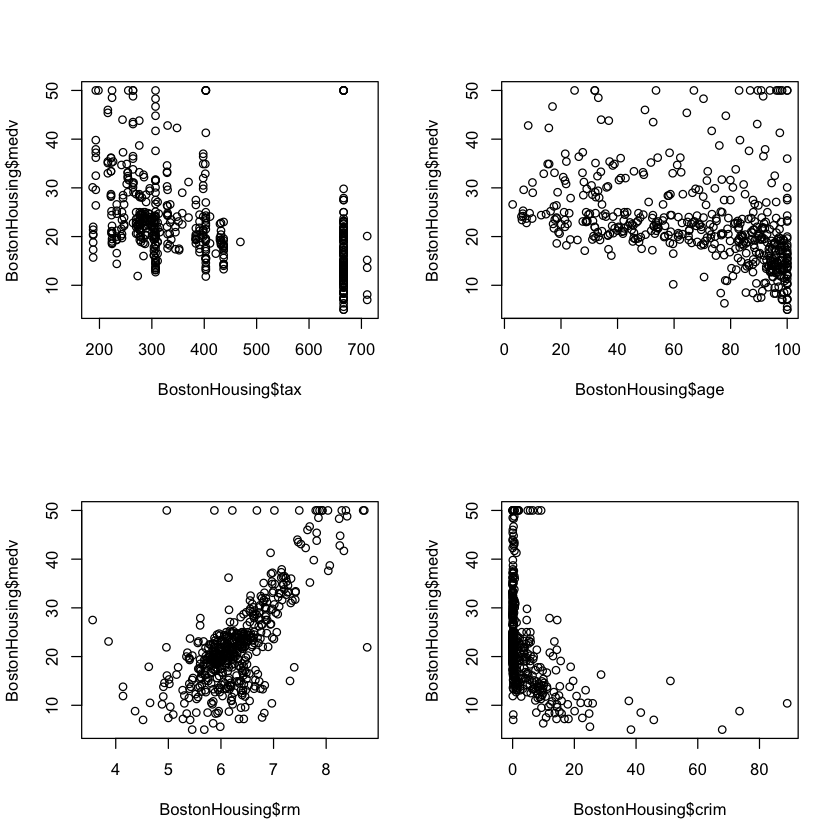

In [2]:
par(mfrow=c(2,2))
plot(BostonHousing$tax,BostonHousing$medv)
plot(BostonHousing$age,BostonHousing$medv)
plot(BostonHousing$rm,BostonHousing$medv)
plot(BostonHousing$crim,BostonHousing$medv)

## (1) Partition data into training and testing.
Stacking occurs in stages.
The first stage partitions your data into a training and test set.

In [33]:
percentTraining = 0.80
BostonHousing['train'] = runif(nrow(BostonHousing)) < percentTraining

training = BostonHousing[BostonHousing$train==1,]
testing  = BostonHousing[BostonHousing$train==0,]

print(head(BostonHousing,10))

print('size of training data')
dim(training)

print('size of testing data')
dim(testing)

      crim   zn indus chas   nox    rm   age    dis rad tax ptratio      b
1  0.00632 18.0  2.31    0 0.538 6.575  65.2 4.0900   1 296    15.3 396.90
2  0.02731  0.0  7.07    0 0.469 6.421  78.9 4.9671   2 242    17.8 396.90
3  0.02729  0.0  7.07    0 0.469 7.185  61.1 4.9671   2 242    17.8 392.83
4  0.03237  0.0  2.18    0 0.458 6.998  45.8 6.0622   3 222    18.7 394.63
5  0.06905  0.0  2.18    0 0.458 7.147  54.2 6.0622   3 222    18.7 396.90
6  0.02985  0.0  2.18    0 0.458 6.430  58.7 6.0622   3 222    18.7 394.12
7  0.08829 12.5  7.87    0 0.524 6.012  66.6 5.5605   5 311    15.2 395.60
8  0.14455 12.5  7.87    0 0.524 6.172  96.1 5.9505   5 311    15.2 396.90
9  0.21124 12.5  7.87    0 0.524 5.631 100.0 6.0821   5 311    15.2 386.63
10 0.17004 12.5  7.87    0 0.524 6.004  85.9 6.5921   5 311    15.2 386.71
   lstat medv train
1   4.98 24.0  TRUE
2   9.14 21.6  TRUE
3   4.03 34.7  TRUE
4   2.94 33.4  TRUE
5   5.33 36.2  TRUE
6   5.21 28.7  TRUE
7  12.43 22.9  TRUE
8  19.15 27.1  

[1] 415  15

[1] "size of testing data"


[1] 91 15

## (2) Cross validation for out-of-sample predictions

Next we split our training data into $K$ folds.
For every fold $k$, we train on the left over $K-1$ folds and make predictions on fold $k$. 
We repeat this process for all $M$ component models.

We will use a KNN neighbor regression, linear regression, polynomial regression, and regression tree to predict the median value of houses (medv).

In [39]:
require(FNN)   # for the KNN model
require(rpart) # for the TBR model

K = 10
training = training[,names(training)!='train']
trainingFolds = split(training,1:K)

dataSetOfPredictions = matrix()
for(k in 1:K){
    sprintf("Fold %d", k)
    
    outOfSample = trainingFolds[[k]]
    outOfSampleX = outOfSample[,names(outOfSample)!='medv']
    
    leftOver = setdiff(1:K,k)
    trainingSamples = do.call(rbind,trainingFolds[leftOver])
    
    trainY = trainingSamples[,names(trainingSamples)=='medv']
    trainX = trainingSamples[,names(trainingSamples)!='medv']
    
    # KNN model
    m1_predictions = knn.reg(train = as.matrix(trainingSamples$crim)
                 ,test = as.matrix(outOfSampleX$crim)
                 ,y=as.matrix(trainY),k=10)$pred
    
    #linear regression
    m2 = lm(medv~., data = trainingSamples)
    m2_predictions = predict(m2,outOfSampleX) 
    
    #polynomial regression
    m3 = lm(medv~tax + age + rm + crim + I(tax^2) + I(age^2) + I(rm^2) + I(crim^2), data = trainingSamples)
    m3_predictions = predict(m3,outOfSampleX) 
    
    #TBR
    m4 = rpart(medv ~ ., method="anova", data=trainingSamples)
    m4_predictions = predict(m4,outOfSampleX) 
    
    # build data set of out-of-sample predictions
    if (k==1){
        allDataSetOfPredictions = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions,trainY)
    } else {
        dataSetOfPredictions    = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions,trainY)
        allDataSetOfPredictions = rbind(allDataSetOfPredictions,dataSetOfPredictions,trainY)
    }
}

Warning message in split.default(x = seq_len(nrow(x)), f = f, drop = drop, ...):
“data length is not a multiple of split variable”
Warning message in cbind(m1_predictions, m2_predictions, m3_predictions, m4_predictions, :
“number of rows of result is not a multiple of vector length (arg 1)”
Warning message in cbind(m1_predictions, m2_predictions, m3_predictions, m4_predictions, :
“number of rows of result is not a multiple of vector length (arg 1)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, trainY):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in cbind(m1_predictions, m2_predictions, m3_predictions, m4_predictions, :
“number of rows of result is not a multiple of vector length (arg 1)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, trainY):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in cbind(m1_predictions, m2_predictions, m3_predictions, m4_pr

We now have a dataset that includes an out-of-sample for prediction, for all $4$ models and for all observation in our training set.

In [40]:
print(head(allDataSetOfPredictions))

 m1_predictions m2_predictions m3_predictions m4_predictions trainY
          34.69      30.747363       24.90661        25.3775   21.6
          26.15      20.473482       21.74700        17.5925   20.4
          22.13      15.836745       19.24050        17.5925   13.9
          27.18      23.911609       21.00925        21.0876   20.0
          18.76       8.919021       19.31691        17.5925   19.7
          24.14      22.014722       27.78422        27.4200   33.0


## (3) Build Aggregator

The next step trains a model that aggregates the $M$ models together by training on the data set of out-of-sample predictions.
We can consider a linear regression model as our aggregator.


In [43]:
agg = lm(trainY~m1_predictions+m2_predictions+m3_predictions+m4_predictions,data = data.frame(allDataSetOfPredictions))
print(summary(agg))


Call:
lm(formula = trainY ~ m1_predictions + m2_predictions + m3_predictions + 
    m4_predictions, data = data.frame(allDataSetOfPredictions))

Residuals:
    Min      1Q  Median      3Q     Max 
-21.052  -5.629  -1.674   3.533  36.329 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    10.74016    0.60623  17.716  < 2e-16 ***
m1_predictions  0.15542    0.03025   5.137 2.93e-07 ***
m2_predictions  0.26294    0.03494   7.526 6.52e-14 ***
m3_predictions -0.01661    0.03966  -0.419 0.675426    
m4_predictions  0.12455    0.03536   3.522 0.000433 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.865 on 3739 degrees of freedom
Multiple R-squared:  0.1374,	Adjusted R-squared:  0.1365 
F-statistic: 148.9 on 4 and 3739 DF,  p-value: < 2.2e-16



These estimates are for our training set. 
We still need to make predictions on our held out test set.

## (4) make predictions on test set

### (4.1) Train Models on whole training set

In [50]:
    # KNN model
    m1_predictions = knn.reg(train = as.matrix(training$crim)
                            ,test = as.matrix(testing$crim)
                            ,y=as.matrix(training$medv),k=10)$pred
    
    #linear regression
    m2 = lm(medv~., data = training)
    m2_predictions = predict(m2,testing) 
    
    #polynomial regression
    m3 = lm(medv~tax + age + rm + crim + I(tax^2) + I(age^2) + I(rm^2) + I(crim^2), data = training)
    m3_predictions = predict(m3,testing) 
    
    #TBR
    m4 = rpart(medv ~ ., method="anova", data=training)
    m4_predictions = predict(m4,testing) 


testSetPredictions = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions)
AggregatorModelPredictionsOnTestSet = predict(agg,data.frame(testSetPredictions))

print(AggregatorModelPredictionsOnTestSet)

      10       12       19       22       34       40       42       44 
20.69625 22.77449 20.35950 20.86065 19.54791 25.93482 25.08254 22.98151 
      50       56       59       62       63       70       74       83 
20.20664 27.60575 22.62655 21.14669 23.37689 22.09355 22.00723 24.97694 
      87       90      112      113      114      115      116      123 
22.64821 26.87657 24.46649 22.04813 21.27338 23.44954 21.11128 21.87311 
     124      126      134      143      152      156      168      169 
20.06635 21.34642 20.75505 19.79120 22.74392 21.30573 24.01421 22.88878 
     177      181      184      195      207      213      215      219 
24.02294 27.05077 25.40939 26.96737 22.36660 21.77531 18.44573 22.75528 
     223      229      235      242      243      244      249      251 
27.40530 28.20853 26.48792 22.85583 22.82411 24.21718 21.74605 23.24770 
     261      265      270      272      273      279      283      301 
28.25513 28.87083 23.95928 23.70026 24.20370 25.773

## (5) Compare your aggregated model to the test set

In [56]:
testSetAndAggPredictions = data.frame('T' = testing$medv
                                      ,'P' = AggregatorModelPredictionsOnTestSet
                                      ,'M1' = m1_predictions
                                      ,'M2' = m2_predictions
                                      ,'M3' = m3_predictions
                                      ,'M4' = m4_predictions)
SSE_AGG = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$P)^2 )

SSE_M1 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M1)^2 )
SSE_M2 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M2)^2 )
SSE_M3 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M3)^2 )
SSE_M4 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M4)^2 )


print(SSE_AGG)
print(SSE_M1)
print(SSE_M2)
print(SSE_M3)
print(SSE_M4)


[1] 2154.833
[1] 3365.197
[1] 1110.28
[1] 964.3875
[1] 1307.686
